# Ridge regression on the G$^3$M model

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import erf
from state_evolution.data_models.custom import CustomSpectra
from state_evolution.experiments.learning_curve import CustomExperiment

from simulation import ridge_estimator, simulate

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preliminaries

## Theory

### The G$^3$M model

In this notebook we try to reproduce the learning curves for the classification of two MNIST digits with the G$^3$M model. Recall that in the G$^3$M we assume that:
- Teacher: $y = \frac{1}{\sqrt{k}}z^{\top}\theta^{0}$ for $\theta^{0}\sim\mathcal{N}(0,\rm{I}_{k})$
- Student: $\hat{y} = \frac{1}{\sqrt{p}}x^{\top}\hat{w}$ for $\hat{w}\in\mathbb{R}^{p}$.
and the vectors $z\in\mathbb{R}^{k}$, $x\in\mathbb{R}^{k}$ are jointly Gaussian variables with covariances given by:
\begin{align}
\Psi = \mathbb{E}zz^{\top} \in\mathbb{R}^{k\times k}, && \Phi = \mathbb{E}zx^{\top} \in\mathbb{R}^{p\times k}
&&\Omega = \mathbb{E}xx^{\top}\in\mathbb{R}^{p\times p}
\end{align}
and the weight vector $w$ is fitted by minimising the regularised empirical risk over $n$ independent samples from the teacher model $\{x^{\mu},y^{\mu}\}_{\mu=1}^{n}$:
\begin{align}
\hat{w} = \underset{w\in\mathbb{R}^{p}}{\rm{argmin}}\left[\frac{1}{2}\sum\limits_{\mu=1}^{n}\left(\frac{1}{\sqrt{k}}z^{\mu}\cdot \theta^{0}-\frac{1}{\sqrt{p}}x^{\mu}\cdot w\right)^2+\frac{\lambda}{2}||w||^2_{2}\right]
\end{align}
This task is particularly simple since wee have a closed form solution for the estimator minimising the empirical risk:
\begin{align}
\hat{w} = 
\begin{cases}
\left(\lambda\text{I}_{p}+X^{\top}X\right)^{-1}X^{\top}y & \text{ for } p \leq n \\
X^{\top}\left(\lambda\text{I}_{n}+XX^{\top}\right)^{-1}y & \text{ for } p > n
\end{cases}
\end{align}

### Applying to real data

With real data, we have only access to a dataset $\{c^{\mu},y^{\mu}\}_{\mu=1}^{n_{tot}}$ where $n_{tot}$ denotes the total number of samples, i.e. the sum of training and test samples in the data set. Note that we have no guarantee that the labels $y^{\mu}$ were generated from a linear model. One idea is to use a feature map $\Phi:\mathbb{R}^{d}\to\mathbb{R}^{k}$ to map the data $z^{\mu} = \Phi(c^{\mu})$ to a space in which it is linearly separable and that allow us to estimate teacher weights $\theta^{*}$. 

**Covariances:** In the G$^3$M model, the covariances are *population covariances*. The best we can do to approximate them is to estimate from the total number of samples $n_{tot}$:
\begin{align}
\Psi = \frac{1}{n_{tot}}Z^{\top}Z, && \Phi = \frac{1}{n_{tot}} X^{\top}Z
&&\Omega = \frac{1}{n_{tot}}X^{\top}X
\end{align}
which converge to the population covariances when $n_{tot}\to\infty$.

**Teacher weights:**  Letting $C \in\mathbb{R}^{n_{tot}\times d}$ be the original data matrix and letting $Z=\Phi(X)\in\mathbb{R}^{n_{tot}\times k}$, we can invert the teacher equation to get the teacher weights $\theta^{\star}$:
\begin{align}
\theta^{\star} = Z^{\dagger}y = \begin{cases}(Z^{\top}Z)^{-1}Z^{\top}y & \text{ if } n_{tot} \geq k \\ 
Z(ZZ^{\top})^{-1}y & \text{ if } n_{tot} < k 
\end{cases}
\end{align}
where $Z^{\dagger}\in\mathbb{R}^{k\times n_{tot}}$ is the pseudo-inverse of $Z$. Note that in the second equality we assumed that $rank(Z) = \rm{min}(k,n_{tot})$ (which is true in particular with high-probability in the random projection case).

Note that in this case the teacher weight $\theta^{\star}\in\mathbb{R}^{k}$ is fixed, while in the G$^3$M model it is a Gaussian vector. This is not a problem: we can map one to another by redefining:
\begin{align}
\tilde{\Phi}\tilde{\Phi}^{\top} = \Phi\theta^{\star}{\theta^{\star}}^{\top}\Phi^{\top}.
\end{align}
and noting that the dependence of the replicas on $\Psi$ is given by:
\begin{align}
\rho = \frac{1}{k}{\theta^{\star}}^{\top}\Psi\theta^{\star}
\end{align}


### Random Features

The simples example of feature map are random features:
\begin{align}
\Phi(c) = \sigma\left(\frac{1}{\sqrt{d}}Fc\right)
\end{align}
where $F\in\mathbb{R}^{k\times d}$ is a random Gaussian matrix and $\sigma$ a component-wise acting real function. This is convenient because when $k\to \infty$ Mercer's theorem tell us that:
\begin{align}
\frac{1}{k}\mathbb{E}_{F}\left[\Phi(c)^{\top}\Phi(c')\right]\underset{k\to\infty}{\to} K(c,c')
\end{align}
for some Kernel $K$ that depends on the choice of $\sigma$. 

In this notebook, we will analyse the case where we use RF both for the teacher and student.

# Experiments

## Pre-processing the data

In [2]:
import torchvision.datasets as datasets
import torch

In [7]:
def preprocess_data(dataset):
    '''
    Take the pyTorch MNIST dataset, flatten the 28x28 images in a 784 dimensional
    array, center the data and divide by the global standard deviation.

    Then select only 8 and 9 digits and assign them {-1,+1} labels.
    '''
    n, d_x, d_y = dataset.data.shape
    d = d_x * d_y
    X = torch.clone(dataset.data).reshape(n,d).float() # flatten
    y = torch.clone(dataset.targets).view(n,).float()
    
    X -= X.mean(dim=0) # center
    X /= X.std() # normalise by global std
    
    data, labels = [], []

    # Extract digits and create labels
    for k,label in enumerate(y):
        if label == 8:
            data.append(X[k].numpy())
            labels.append(1)
        elif label == 9:
            data.append(X[k].numpy())
            labels.append(-1)

    return np.array(data), np.array(labels)

In [4]:
# Load MNIST 
mnist_testset = datasets.MNIST(root='data', train=False, 
                               download=True, transform=None)

mnist_trainset= datasets.MNIST(root='data', train=True, 
                               download=True, transform=None)

# Pre-process
X_train, y_train = preprocess_data(mnist_trainset)
X_test, y_test = preprocess_data(mnist_testset)

# Join in a single dataset
C, y = (np.concatenate((X_train, X_test), axis=0 ), 
        np.concatenate((y_train, y_test), axis=0))

## Global Variables

In [5]:
# Dimensions
n_tot, d = C.shape
k = n_tot
p = int(3*d)

# Regularisation
lamb = 0.01

# Ratio between teacher-student features
gamma = k/p

# Projections
F_teacher = np.random.normal(0,1, (k,d)) / np.sqrt(d) # Teacher projection
F_student = np.random.normal(0,1, (p,d)) / np.sqrt(d) # Student projection

# Projected data
Z = erf(C @ F_teacher.T)
X = erf(C @ F_student.T)

## Replicas 

First, we need estimate the covariance matrices and the teacher vector.

In [8]:
# Covariances
print('Computing covariances')
Omega = X.T @ X / n_tot # student-student
Phi = X.T @ Z / n_tot # student-teacher
Psi = Z.T @ Z / n_tot # teacher-teacher

# Teacher weights
print('Computing teacher weights')
teacher = ridge_estimator(Z/np.sqrt(k), y, lamb=0) # pseudo-inverse estimator

Computing covariances
Computing teacher weights


Then, we compute the quantities needed for the replicas

In [9]:
print('Computing rho')
rho = teacher.dot(Psi @ teacher) / k

print('Diagonalising the student-student covariance')
spec_Omega, U = np.linalg.eigh(Omega)

print('Projecting teacher-student correlation on student-student basis')
diagUtPhiPhitU = np.diag(U.T @ Phi @ teacher.reshape(k,1) @ 
                         teacher.reshape(1,k) @ Phi.T @ U)

Now we initialise our data model

In [19]:
print('Loading data model')
data_model = CustomSpectra(gamma = gamma,
                           rho = rho, 
                           spec_Omega = spec_Omega, 
                           spec_UPhiPhitUT = diagUtPhiPhitU)

print('Loading experiment')
experiment = CustomExperiment(task = 'ridge_regression', 
                              regularisation = lamb, 
                              data_model = data_model, 
                              tolerance = 1e-7, 
                              damping = 0.5, 
                              verbose = False, 
                              max_steps = 1000)

Loading data model
Loading experiment


Now let's compute the learning curve

In [26]:
alphas = np.linspace(0.01, 3, 100)
experiment.learning_curve(alphas = alphas)

We can now get the learning curve as a pandas dataframe

In [27]:
replicas = experiment.get_curve()

## Simulations

In [35]:
print('Simulating with no trick')
sim_mnist_notrick = simulate(sc_range = np.linspace(0.1, 2.5, 10),
                             X = X,
                             y = y,
                             task = 'regression',
                             loss = 'l2',
                             lamb = lamb, 
                             seeds = 10, 
                             trick=False)

print('Simulating with trick')
sim_mnist_trick = simulate(sc_range = np.linspace(0.1, 2.5, 10),
                           X = X,
                           y = y,
                           task = 'regression',
                           loss = 'l2',
                           lamb = lamb, 
                           seeds = 10, 
                           trick=True)

Simulating with no trick
Simulating sample complexity: 0.1
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 0.3666666666666667
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 0.6333333333333333
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 0.9
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 1.1666666666666667
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 1.4333333333333333
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 1.7000000000000002
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed: 6
Seed: 7
Seed: 8
Seed: 9
Simulating sample complexity: 1.9666666666666668
Seed: 0
Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5
Seed:

## Plots

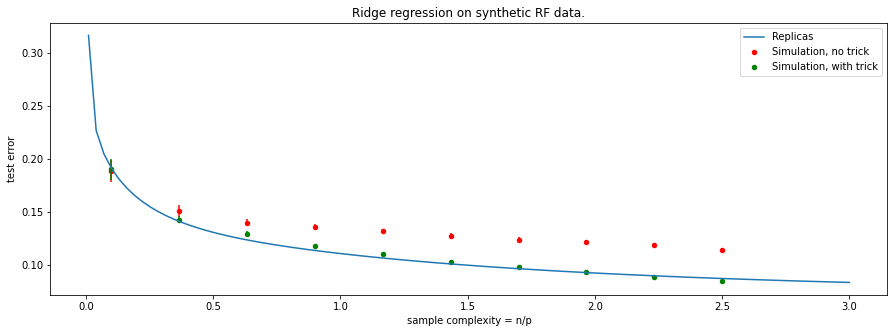

In [36]:
fig, ax = plt.subplots(figsize=(15,5))

plt.title('Ridge regression on synthetic RF data.')

replicas.plot(x='sample_complexity', y='test_error', style='-', 
              ax=ax, label='Replicas')

sim_mnist_notrick.plot(x='sample_complexity', y='test_error', style='.', 
                           kind='scatter',  c='r', yerr='test_error_std', ax=ax,
                           label='Simulation, no trick')

sim_mnist_trick.plot(x='sample_complexity', y='test_error', style='.', 
                         kind='scatter',  c='g', yerr='test_error_std', ax=ax,
                         label='Simulation, with trick')

plt.ylabel(r"test error")
plt.xlabel(r"sample complexity = n/p")

plt.legend()

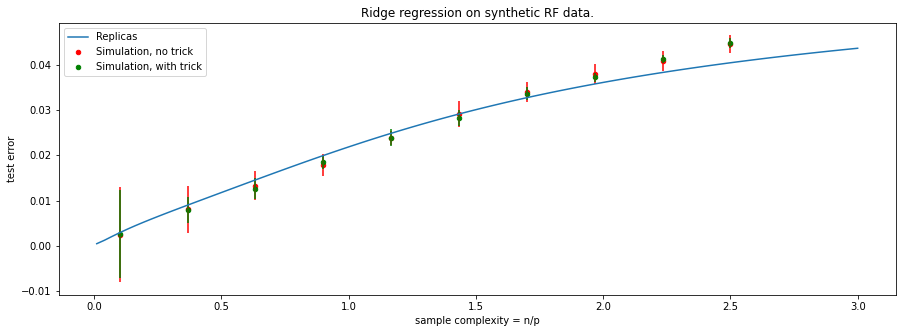

In [37]:
fig, ax = plt.subplots(figsize=(15,5))

plt.title('Ridge regression on synthetic RF data.')

replicas.plot(x='sample_complexity', y='train_loss', style='-', 
              ax=ax, label='Replicas')

sim_mnist_notrick.plot(x='sample_complexity', y='train_error', style='.', 
                           kind='scatter',  c='r', yerr='test_error_std', ax=ax,
                           label='Simulation, no trick')

sim_mnist_trick.plot(x='sample_complexity', y='train_error', style='.', 
                         kind='scatter',  c='g', yerr='test_error_std', ax=ax,
                         label='Simulation, with trick')

plt.ylabel(r"test error")
plt.xlabel(r"sample complexity = n/p")

plt.legend()